In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nure = pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\Spreadsheets\nure.csv')
imputed = pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\Spreadsheets\nure_imputed.csv')

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (19,20,28,29,31,35,46,47,48,66,68,79,145) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
abund = pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\Spreadsheets\critical_abundance.csv')

In [4]:
#gets interesting imputed samples
countsi = {}
for element in imputed.columns[1:-2]:
    try:
        sample_nums = imputed[imputed[element] > abund.loc[5][element]*5]['Unnamed: 0']
        for sample in sample_nums:
            if sample in countsi:
                countsi[sample] += 1
            else:
                countsi[sample] = 1
    except:
        pass

In [5]:
from operator import itemgetter
sorted(countsi.items(), key=itemgetter(1), reverse=True)
besti = sorted(countsi, key=countsi.get, reverse=True)[:250]

In [6]:
latsi = imputed[imputed['Unnamed: 0'].isin(besti)].latitude.values
longsi = imputed[imputed['Unnamed: 0'].isin(besti)].longitude.values

In [7]:
#get the best imputed values from the nure list
top_imputed = nure[(nure['latitude'].isin(latsi)) & (nure['longitude'].isin(longsi))].copy()
top_imputed['counts'] = pd.Series(countsi)

In [8]:
countsn = {}
for element in nure.columns[81:-8]:
    try:
        sample_nums = nure[nure[element] > abund.loc[5][element]*5].index
        for sample in sample_nums:
            if sample in countsn:
                countsn[sample] += 1
            else:
                countsn[sample] = 1
    except:
        pass

In [9]:
from operator import itemgetter
sorted(countsn.items(), key=itemgetter(1), reverse=True)
bestn = sorted(countsn, key=countsn.get, reverse=True)[:250]

In [10]:
top_nure = nure[nure.index.isin(bestn)].copy()
top_nure['counts'] = pd.Series(countsn)

In [11]:
#delete duplicates with a merge on rec_no
combined = top_imputed.merge(top_nure, how='outer', on='rec_no', indicator=True) #nure is right, imputed is left

Text(0.5, 1.0, 'IMPUTED SAMPLES OF INTEREST')

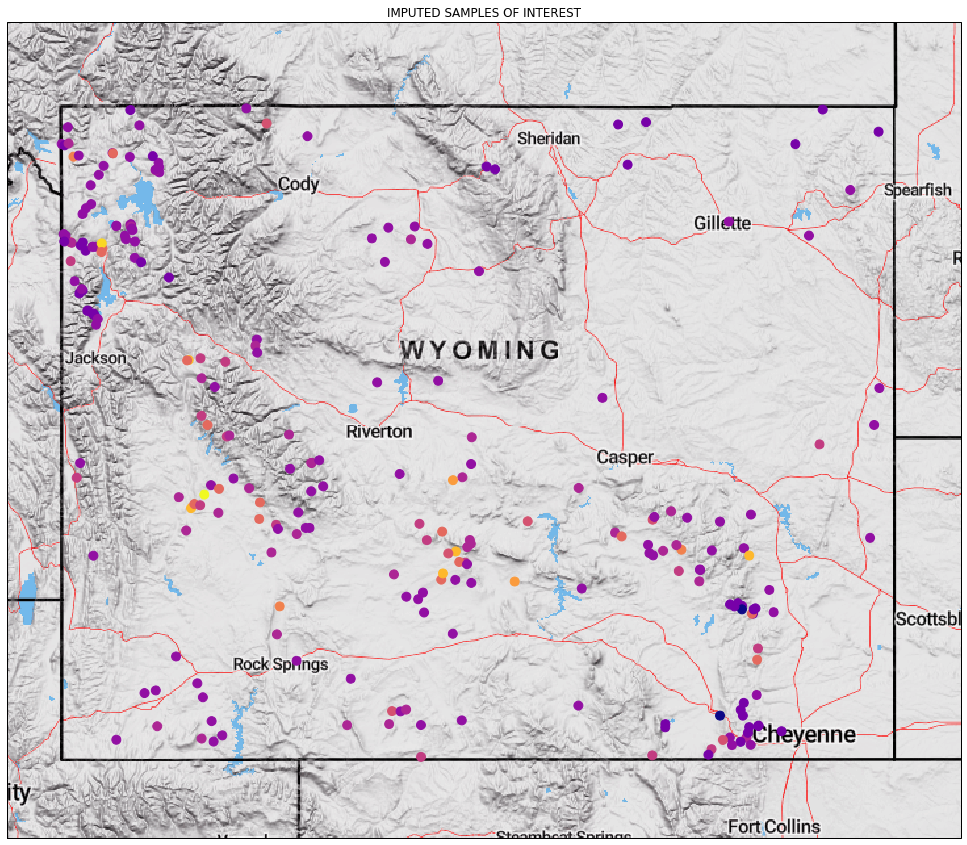

In [12]:
import cartopy
import cartopy.crs as ccrs #import the coordinate refernce system
import cartopy.io.img_tiles as cimgt #this is for calling map tiles from mapbox
mapbox = cimgt.MapboxStyleTiles('pk.eyJ1IjoiamVzc2VwaXNlbCIsImEiOiJjanN3MG43Z2wwNmFoNDNzMTJncDdqMDV0In0.LCWlSCTZwv2j-9V5o1egWw', 'jessepisel', 'cjnlyd3ll0qh42smrrbe8q8c4')
#this creates a mapbox object that has an access token, username, and a mapID, this is the basemap we are going to use underneath our plot

fig = plt.figure(figsize=(20,15)) #I like bigger figures
ax = plt.axes(projection=mapbox.crs) #this sets our plot axes to the mapbox coordinate reference system
ax.set_extent([-103.5, -111.5, 40.5, 45.5])
ax.add_image(mapbox, 7)

plt.scatter(combined.longitude_x, combined.latitude_x,s=80, transform=ccrs.Geodetic(), marker='o', c=combined.counts_x, cmap='plasma')
plt.title('IMPUTED SAMPLES OF INTEREST')



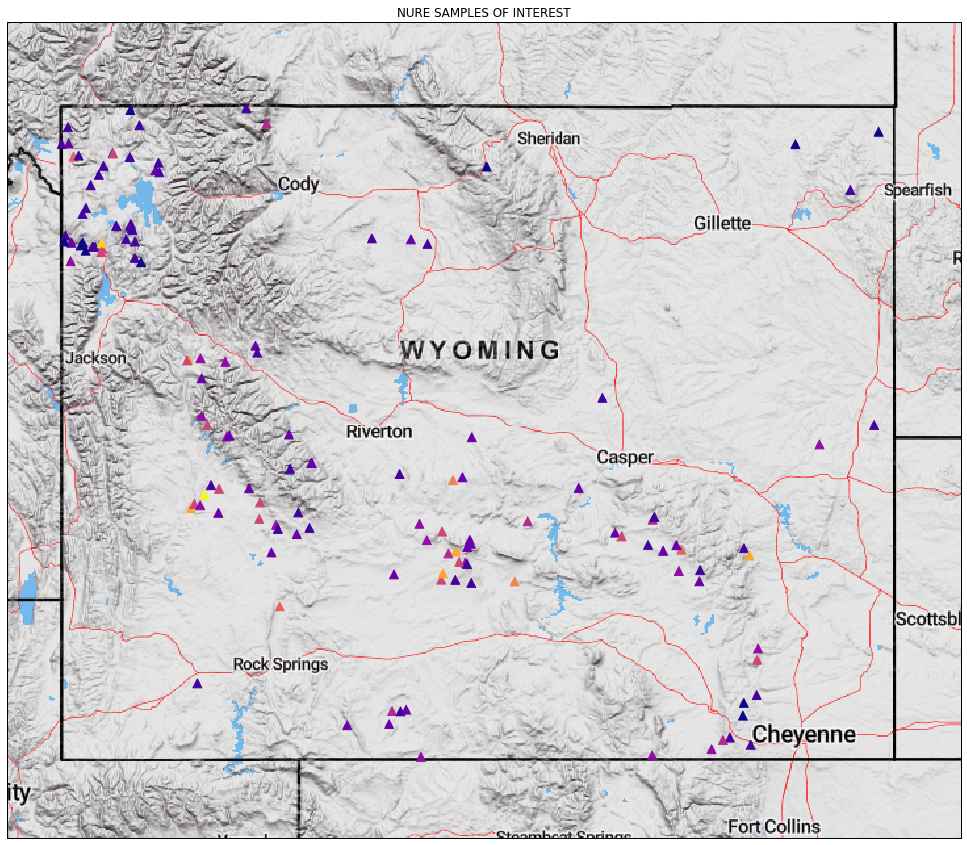

In [13]:
fig = plt.figure(figsize=(20,15)) #I like bigger figures
ax = plt.axes(projection=mapbox.crs) #this sets our plot axes to the mapbox coordinate reference system
ax.set_extent([-103.5, -111.5, 40.5, 45.5])
ax.add_image(mapbox, 7)
plt.title('NURE SAMPLES OF INTEREST')
plt.scatter(combined.longitude_y, combined.latitude_y,s=80, transform=ccrs.Geodetic(), marker ='^',c=combined.counts_x, cmap='plasma')

In [14]:
len(combined[combined._merge == 'left_only']), len(combined[combined._merge == 'right_only']), len(combined[combined._merge == 'both'])

(105, 109, 141)

This section let's go ahead and get rid of samples in national parks and wilderness areas

In [15]:
import geopandas as gpd
from shapely.geometry import Point

In [16]:
nogo = gpd.read_file(r'J:\Geology\WSGS\GIS\land ownership\forbidden_zones.shp')

In [17]:
nogo = nogo.to_crs({'init' :'epsg:4326'})

In [18]:
#create our geometry list from the imputed data
geometry = [Point(xy) for xy in zip(top_imputed.longitude, top_imputed.latitude)]
crs = {'init': 'epsg:4326'}
gdf_i = gpd.GeoDataFrame(top_imputed, crs=crs, geometry=geometry)

#create our geometry list from the nure data
geometry = [Point(xy) for xy in zip(top_nure.longitude, top_nure.latitude)]
crs = {'init': 'epsg:4326'}
gdf_n = gpd.GeoDataFrame(top_nure, crs=crs, geometry=geometry)

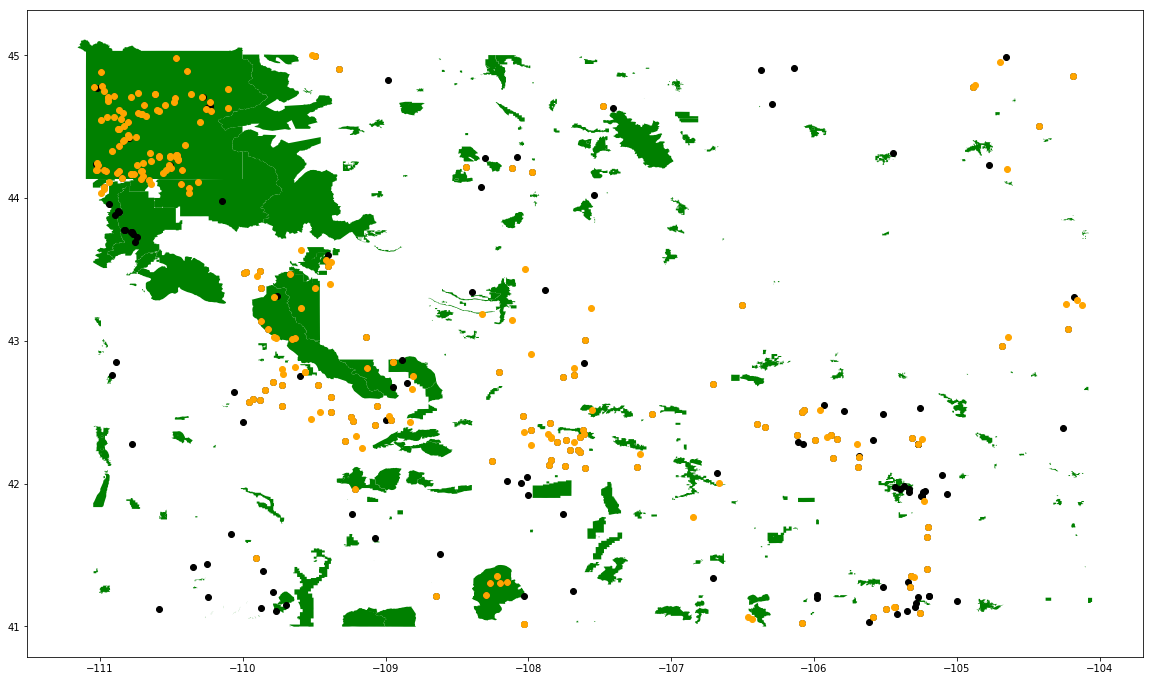

In [19]:
base = nogo.plot(color='green', figsize=(20,15))
gdf_i.plot(ax=base, color="black")
gdf_n.plot(ax=base, color='orange')

In [20]:
imputed_joined = gpd.sjoin(nogo, gdf_i, how='right')
nure_joined = gpd.sjoin(nogo, gdf_n, how='right')

In [21]:
fair_game_i = imputed_joined[~imputed_joined['Res_Name'].isin(imputed_joined['Res_Name'].unique()[:-1])]
fair_game_n = nure_joined[~nure_joined['Res_Name'].isin(nure_joined['Res_Name'].unique()[:-1])]

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


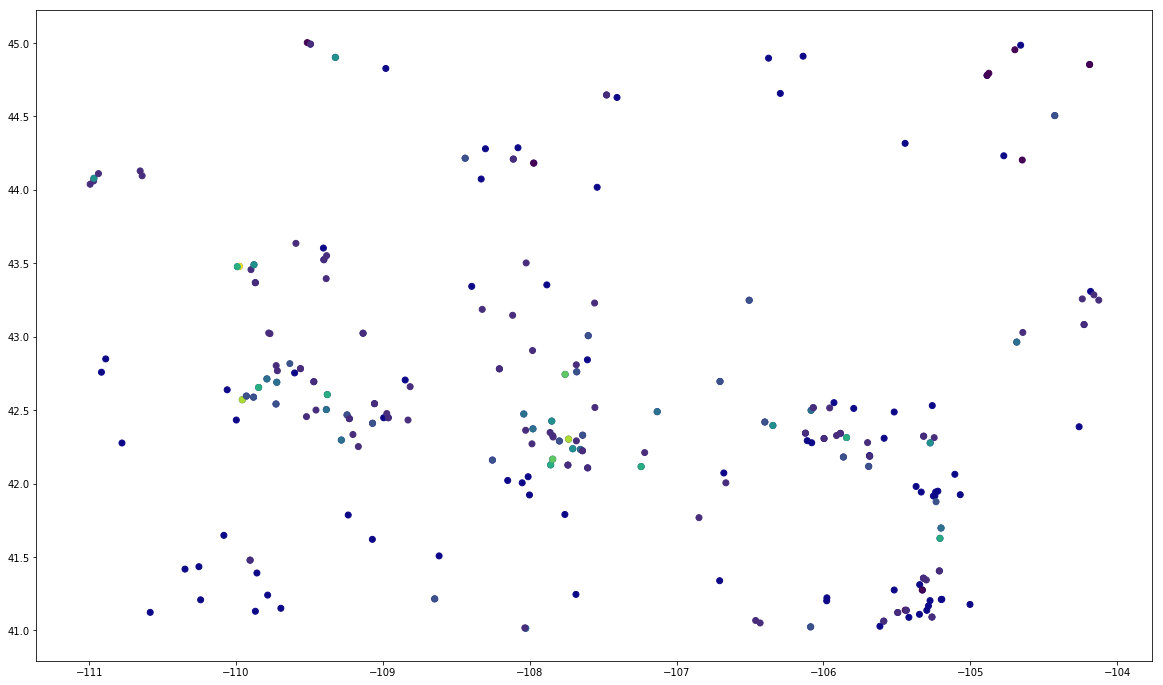

In [22]:
bottom = fair_game_i.plot(column='counts', cmap='plasma', figsize=(20,15))
fair_game_n.plot(column='counts', ax=bottom, cmap='viridis')

In [23]:
combined = fair_game_i.merge(fair_game_n, how='outer', on='rec_no', indicator=True) #nure is right, imputed is left

Text(0.5, 1.0, 'IMPUTED SAMPLES OF INTEREST')

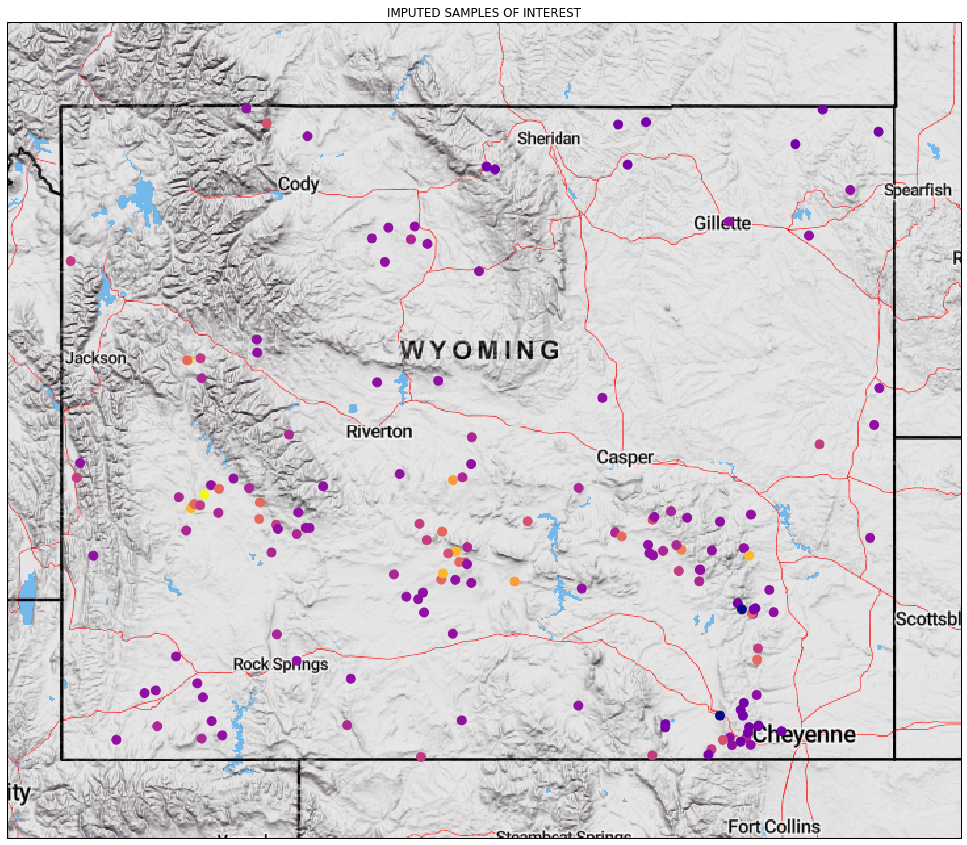

In [24]:
fig = plt.figure(figsize=(20,15)) #I like bigger figures
ax = plt.axes(projection=mapbox.crs) #this sets our plot axes to the mapbox coordinate reference system
ax.set_extent([-103.5, -111.5, 40.5, 45.5])
ax.add_image(mapbox, 7)

plt.scatter(combined.longitude_x, combined.latitude_x,s=80, transform=ccrs.Geodetic(), marker='o', c=combined.counts_x, cmap='plasma')
plt.title('IMPUTED SAMPLES OF INTEREST')

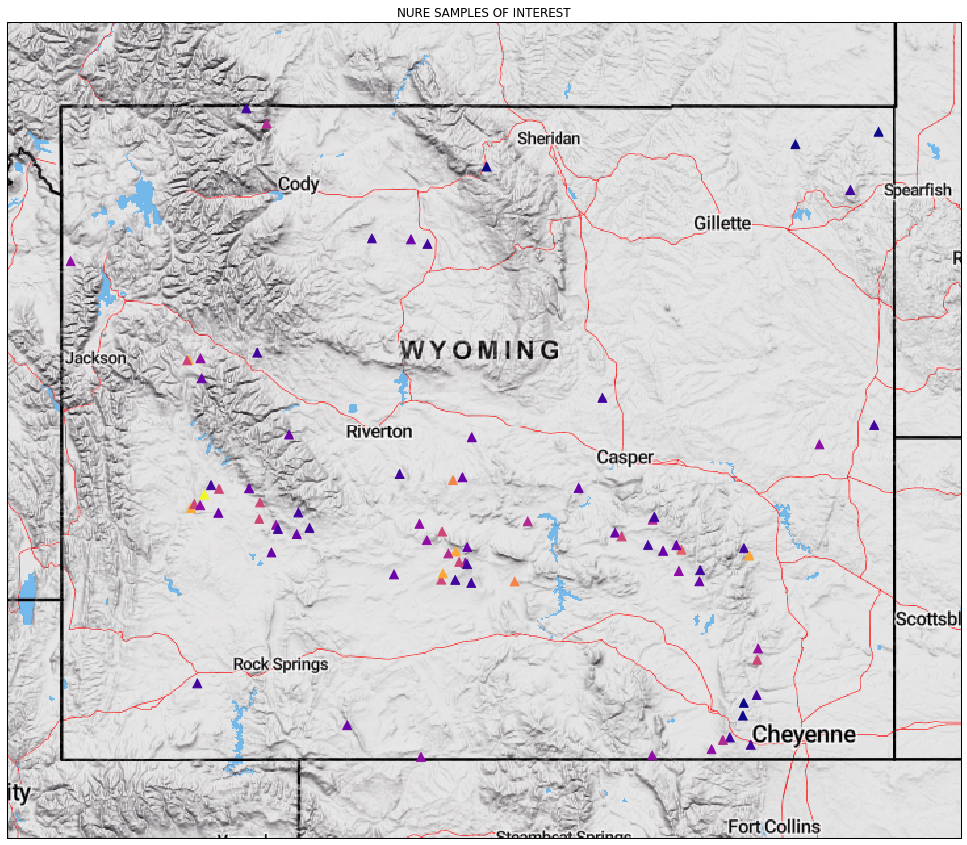

In [25]:
fig = plt.figure(figsize=(20,15)) #I like bigger figures
ax = plt.axes(projection=mapbox.crs) #this sets our plot axes to the mapbox coordinate reference system
ax.set_extent([-103.5, -111.5, 40.5, 45.5])
ax.add_image(mapbox, 7)
plt.title('NURE SAMPLES OF INTEREST')
plt.scatter(combined.longitude_y, combined.latitude_y,s=80, transform=ccrs.Geodetic(), marker ='^',c=combined.counts_x, cmap='plasma')

In [26]:
len(combined[combined._merge == 'left_only']), len(combined[combined._merge == 'right_only']), len(combined[combined._merge == 'both'])

(78, 57, 82)

In [27]:
88+72+99

259